In [40]:
import logging, json, sys
import numpy as np
import pandas as pd
import time
from datetime import datetime

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

logger = logging.getLogger(__name__)

In [41]:
MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

In [42]:
# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

In [43]:
dfknobs

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3
SL1,0.000000,0,0,0,1,0,0
SL2,0.000000,0,0,0,0,1,0
SL3,0.000000,0,0,0,0,0,1
SH1,0.000000,1,0,0,0,0,0
SH3,0.000000,0,1,0,0,0,0
SH4,0.000000,0,0,1,0,0,0
SM1A,-0.663666,0,0,0,0,0,0
SM1B,0.744816,0,0,0,0,0,0
SM2B,-0.086576,0,0,0,0,0,0


This notebook uses:
- Absolute K2L offsets per knob as variables
- Absolute K2L values per family as inputs to the evaluation function
- Lifetime as the objective

### SETUP SINGLE-OBJECTIVE RUN

In [44]:
# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

initial_values['SM1A'] *= 1.01
initial_values['SM1B'] *= 1.008

# optimizer variables in units of K2L
variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
# variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    # variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

objectives_active = {'LT':'MAXIMIZE'}
#objectives_active = {'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

# Manual modifications
initial_variable_values['SH1'] -= 0.2
initial_variable_values['SH3'] -= 0.08
initial_variable_values['SL2'] -= 0.5
initial_variable_values['SL3'] -= 0.5

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.6 -0.396658 -0.117102 -0.316418 -0.265432 -0.713558 -0.589217
1   0.6  0.396658  0.117102  0.316418  0.265432  0.713558  0.589217


In [45]:
if False:
    for k in list(initial_variable_values):
        initial_variable_values[k] = 0.0
    initial_variable_values

In [46]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

In [47]:
# TEST = True
TEST = False

if TEST:
    from opt_funcs_nsls import make_dummy_eval_lifetime
    eval_f = make_dummy_eval_lifetime(gvocs)
else:
    sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-26_APSU_DA_MA")
    import opt_funcs

    def knobs_to_family(inputs_dict):
        d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
        return opt_funcs.master_eval_function(d, meas_lifetime=True)

    eval_f = knobs_to_family

In [48]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.265 -> -2.920
SL2: 7.136 + -0.714 -> 6.422
SL3: -5.892 + -0.589 -> -6.481
SH1: 3.967 + -0.397 -> 3.570
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + 0.398 -> -4.385
SM1B: -5.231 + -0.447 -> -5.678
SM2B: 7.161 + 0.052 -> 7.213


{'SL1': -2.9197533310000003,
 'SL2': 6.422025861000001,
 'SL3': -6.481389334200001,
 'SH1': 3.5699241780000004,
 'SH3': -1.2881238501999999,
 'SH4': -3.4805981562,
 'SM1A': -4.385288760620001,
 'SM1B': -5.6776103901960004,
 'SM2B': 7.2127339758749995}

In [49]:
if True:
    opt_funcs.master_eval_function(inputs_dict, meas_lifetime=True)


Sextupole adj. took 10.5.
RMS(dx, dy) [m] = (9.953e-05, 4.520e-06)
RMS(dx, dy) [m] = (3.834e-05, 4.570e-06)
RMS(dx, dy) [m] = (1.893e-05, 4.165e-06)
RMS(dx, dy) [m] = (3.071e-05, 6.549e-06)
RMS(dx, dy) [m] = (3.981e-05, 4.405e-06)
RMS(dx, dy) [m] = (7.181e-05, 8.185e-06)
RMS(dx, dy) [m] = (1.511e-05, 2.889e-06)
RMS(dx, dy) [m] = (1.165e-05, 3.134e-06)
RMS(dx, dy) [m] = (1.510e-05, 1.792e-06)
RMS(dx, dy) [m] = (4.356e-06, 1.190e-06)
Orbit correction converged
** # of outliers found = 2 (out of 180)
Lifetime = 2.944 (raw tau [hr] = 3.397, epsy [pm] = 17.46) (took 3.1 [s])
Eval. func. finished.


In [50]:
#PRESET = 'SOBO1'
PRESET = 'SOBO2'
#PRESET = 'SOBO3'

In [51]:
ev = FunctionEvaluator(script=eval_f)

generator_name = 'bo_ucb'
gc = get_generator_class(generator_name)
tc = 'optimize' if PRESET == 'SOBO1' else None
beta = 5.0 if PRESET == 'SOBO3' else 1.0

gen = gc(gvocs=gvocs,
        turbo_controller=tc,
        beta=beta,
        )
gen.numerical_optimizer.n_raw_samples = 128
gen.numerical_optimizer.n_restarts = 16
gen.gp_constructor.use_low_noise_prior = False

options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

### Sample at initial values

In [52]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + -0.500 -> 6.636
SL3: -5.892 + -0.500 -> -6.392
SH1: 3.967 + -0.200 -> 3.767
SH3: -1.171 + -0.080 -> -1.251
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.783 + 0.000 -> -4.783
SM1B: -5.231 + 0.000 -> -5.231
SM2B: 7.161 + 0.000 -> 7.161


Sextupole adj. took 5.3.
RMS(dx, dy) [m] = (7.812e-05, 4.764e-06)
RMS(dx, dy) [m] = (1.210e-04, 4.478e-06)
RMS(dx, dy) [m] = (1.260e-05, 2.316e-06)
RMS(dx, dy) [m] = (6.458e-05, 3.664e-06)
RMS(dx, dy) [m] = (6.364e-06, 1.042e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 3.633 (raw tau [hr] = 4.195, epsy [pm] = 17.43) (took 4.2 [s])
Eval. func. finished.


In [53]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT
1,0.0,-0.2,-0.08,0.0,0.0,-0.5,-0.5,"{'_eps_x_bxbOff': 2.268571594207405e-09, '_eps...",None,,22.500301,8.661341,True,2.268572e-09,1.742895e-11,3.633233,4.195247


### Sample close to initial point

In [54]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

SL1: -2.654 + -0.003 -> -2.657
SL2: 7.136 + -0.496 -> 6.639
SL3: -5.892 + -0.499 -> -6.392
SH1: 3.967 + -0.190 -> 3.777
SH3: -1.171 + -0.077 -> -1.248
SH4: -3.164 + -0.016 -> -3.180
SM1A: -4.783 + -0.001 -> -4.785
SM1B: -5.231 + 0.002 -> -5.229
SM2B: 7.161 + -0.000 -> 7.161
Sextupole adj. took 0.1.
RMS(dx, dy) [m] = (3.750e-06, 3.022e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 3.684 (raw tau [hr] = 4.252, epsy [pm] = 17.36) (took 4.7 [s])
Eval. func. finished.


In [55]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT
1,0.000000,-0.200000,-0.08000,0.000000,0.000000,-0.500000,-0.500000,"{'_eps_x_bxbOff': 2.268571594207405e-09, '_eps...",None,,22.500301,8.661341,True,2.268572e-09,1.742895e-11,3.633233,4.195247
2,0.002046,-0.189556,-0.07705,-0.015575,-0.002693,-0.496382,-0.499483,"{'_eps_x_bxbOff': 2.2693016683050873e-09, '_ep...",None,,5.833045,7.780350,True,2.269302e-09,1.736042e-11,3.684426,4.252113


### Run optimizer

In [56]:
opt.step()

SL1: -2.654 + -0.055 -> -2.709
SL2: 7.136 + -0.427 -> 6.709
SL3: -5.892 + -0.489 -> -6.381
SH1: 3.967 + 0.011 -> 3.978
SH3: -1.171 + -0.020 -> -1.191
SH4: -3.164 + -0.315 -> -3.479
SM1A: -4.783 + -0.027 -> -4.810
SM1B: -5.231 + 0.030 -> -5.200
SM2B: 7.161 + -0.004 -> 7.157
Sextupole adj. took 3.3.
RMS(dx, dy) [m] = (3.142e-05, 1.912e-06)
RMS(dx, dy) [m] = (4.350e-05, 3.742e-06)
RMS(dx, dy) [m] = (1.310e-05, 2.029e-06)
RMS(dx, dy) [m] = (1.720e-05, 1.666e-06)
RMS(dx, dy) [m] = (3.841e-06, 1.005e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 4.799 (raw tau [hr] = 5.536, epsy [pm] = 17.30) (took 5.0 [s])
Eval. func. finished.


In [57]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()


** Step #1 at 2023-11-26 21:04:41**

SL1: -2.654 + -0.098 -> -2.753
SL2: 7.136 + -0.368 -> 6.768
SL3: -5.892 + -0.481 -> -6.373
SH1: 3.967 + 0.181 -> 4.148
SH3: -1.171 + 0.027 -> -1.144
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + -0.049 -> -4.832
SM1B: -5.231 + 0.055 -> -5.176
SM2B: 7.161 + -0.006 -> 7.154
Sextupole adj. took 2.2.
RMS(dx, dy) [m] = (4.435e-05, 1.716e-06)
RMS(dx, dy) [m] = (8.541e-06, 8.521e-07)
Orbit correction converged
** # of outliers found = 13 (out of 180)
Lifetime = 5.538 (raw tau [hr] = 6.389, epsy [pm] = 17.27) (took 5.1 [s])
Eval. func. finished.

** Step #2 at 2023-11-26 21:04:54**

SL1: -2.654 + -0.136 -> -2.790
SL2: 7.136 + -0.317 -> 6.819
SL3: -5.892 + -0.473 -> -6.365
SH1: 3.967 + 0.327 -> 4.293
SH3: -1.171 + 0.069 -> -1.102
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + -0.067 -> -4.851
SM1B: -5.231 + 0.076 -> -5.155
SM2B: 7.161 + -0.009 -> 7.152
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (4.603e-05, 2.438e-06)
RMS(dx, dy) [m] = (4.370e-06, 1.421e-06)


In [58]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT
19,-0.270182,0.390673,0.038640,-0.316418,-0.012919,-0.025788,-0.508386,"{'_eps_x_bxbOff': 2.2703044983319242e-09, '_ep...",None,,29.196353,16.463427,True,2.270304e-09,1.654462e-11,5.873866,6.686612
20,-0.100290,0.385481,0.041016,-0.316418,-0.011723,-0.158482,-0.488605,"{'_eps_x_bxbOff': 2.270975407012585e-09, '_eps...",None,,23.445560,33.572714,True,2.270975e-09,1.651236e-11,5.947714,6.769792
21,-0.140110,0.355883,0.052129,-0.316418,-0.030337,-0.079558,-0.456969,"{'_eps_x_bxbOff': 2.2694318619239817e-09, '_ep...",None,,19.491024,29.998796,True,2.269432e-09,1.651239e-11,5.901073,6.721268
22,-0.096283,0.396658,0.044524,-0.316418,0.024284,-0.031083,-0.394716,"{'_eps_x_bxbOff': 2.2693815950962855e-09, '_ep...",None,,17.522584,28.605525,True,2.269382e-09,1.650448e-11,5.968801,6.800234
23,-0.052872,0.396658,0.043574,-0.316418,0.012464,-0.031615,-0.460952,"{'_eps_x_bxbOff': 2.269306047810606e-09, '_eps...",None,,11.071918,21.709080,True,2.269306e-09,1.650065e-11,5.894912,6.717293


### Plot

In [59]:
ol = list(objectives_active.keys())

Text(0, 0.5, 'Objective')

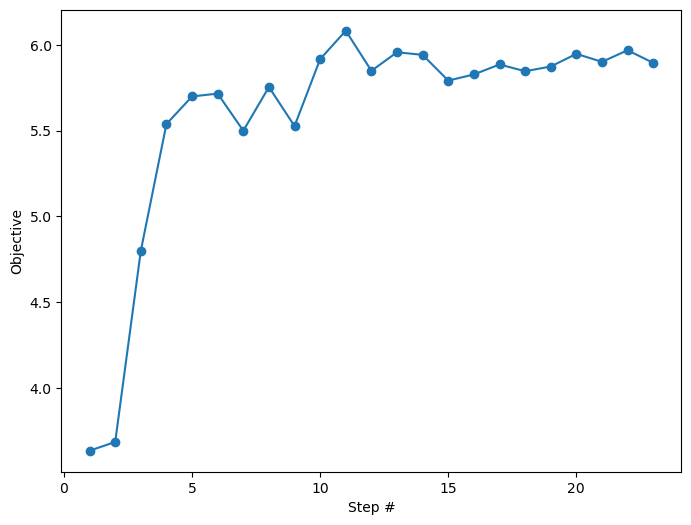

In [60]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,ol[0]],marker='o')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Objective')

In [ ]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [61]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_sobo_inj_eff_dump.json')

'{\n  "optimizer": {\n    "tag": "dbebdf07ec",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "bo_ucb",\n    "n_monte_carlo_samples": 128,\n    "turbo_controller": null,\n    "use_cuda": false,\n    "gp_constructor": {\n      "name": "standard",\n      "use_low_noise_prior": false,\n      "covar_modules": {},\n      "mean_modules": {},\n      "trainable_mean_keys": []\n    },\n    "numerical_optimizer": {\n      "name": "APSLBFGS",\n      "n_raw_samples": 128,\n      "n_restarts": 16,\n      "max_iter": 2000,\n      "sequential": true\n    },\n    "max_travel_distances": null,\n    "fixed_features": null,\n    "computation_time": null,\n    "n_candidates": 1,\n    "beta": 1.0\n  },\n  "evaluator": {\n    "name": "func",\n    "on_error": "ignore",\n    "max_workers": 1,\n    "script": "__main__.knobs_to_family",\n    "post_script": null,\n    "script_kwargs": {},\n    "eval_cnt"